In [2]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("yuriykatser/skoltech-anomaly-benchmark-skab")

print("Path to dataset files:", path)

/home/zepeng/miniconda3/envs/TS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/zepeng/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1


In [6]:
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# anomaly - free
anomaly_free_files = sorted([f for f in csv_files if "anomaly-free" in f])

# anomaly
anomaly_files = sorted([f for f in csv_files if "anomaly-free" not in f])

print(f"anomaly_free: {len(anomaly_free_files)}")
print(f"with_anomaly: {len(anomaly_files)}")


anomaly_free: 1
with_anomaly: 34


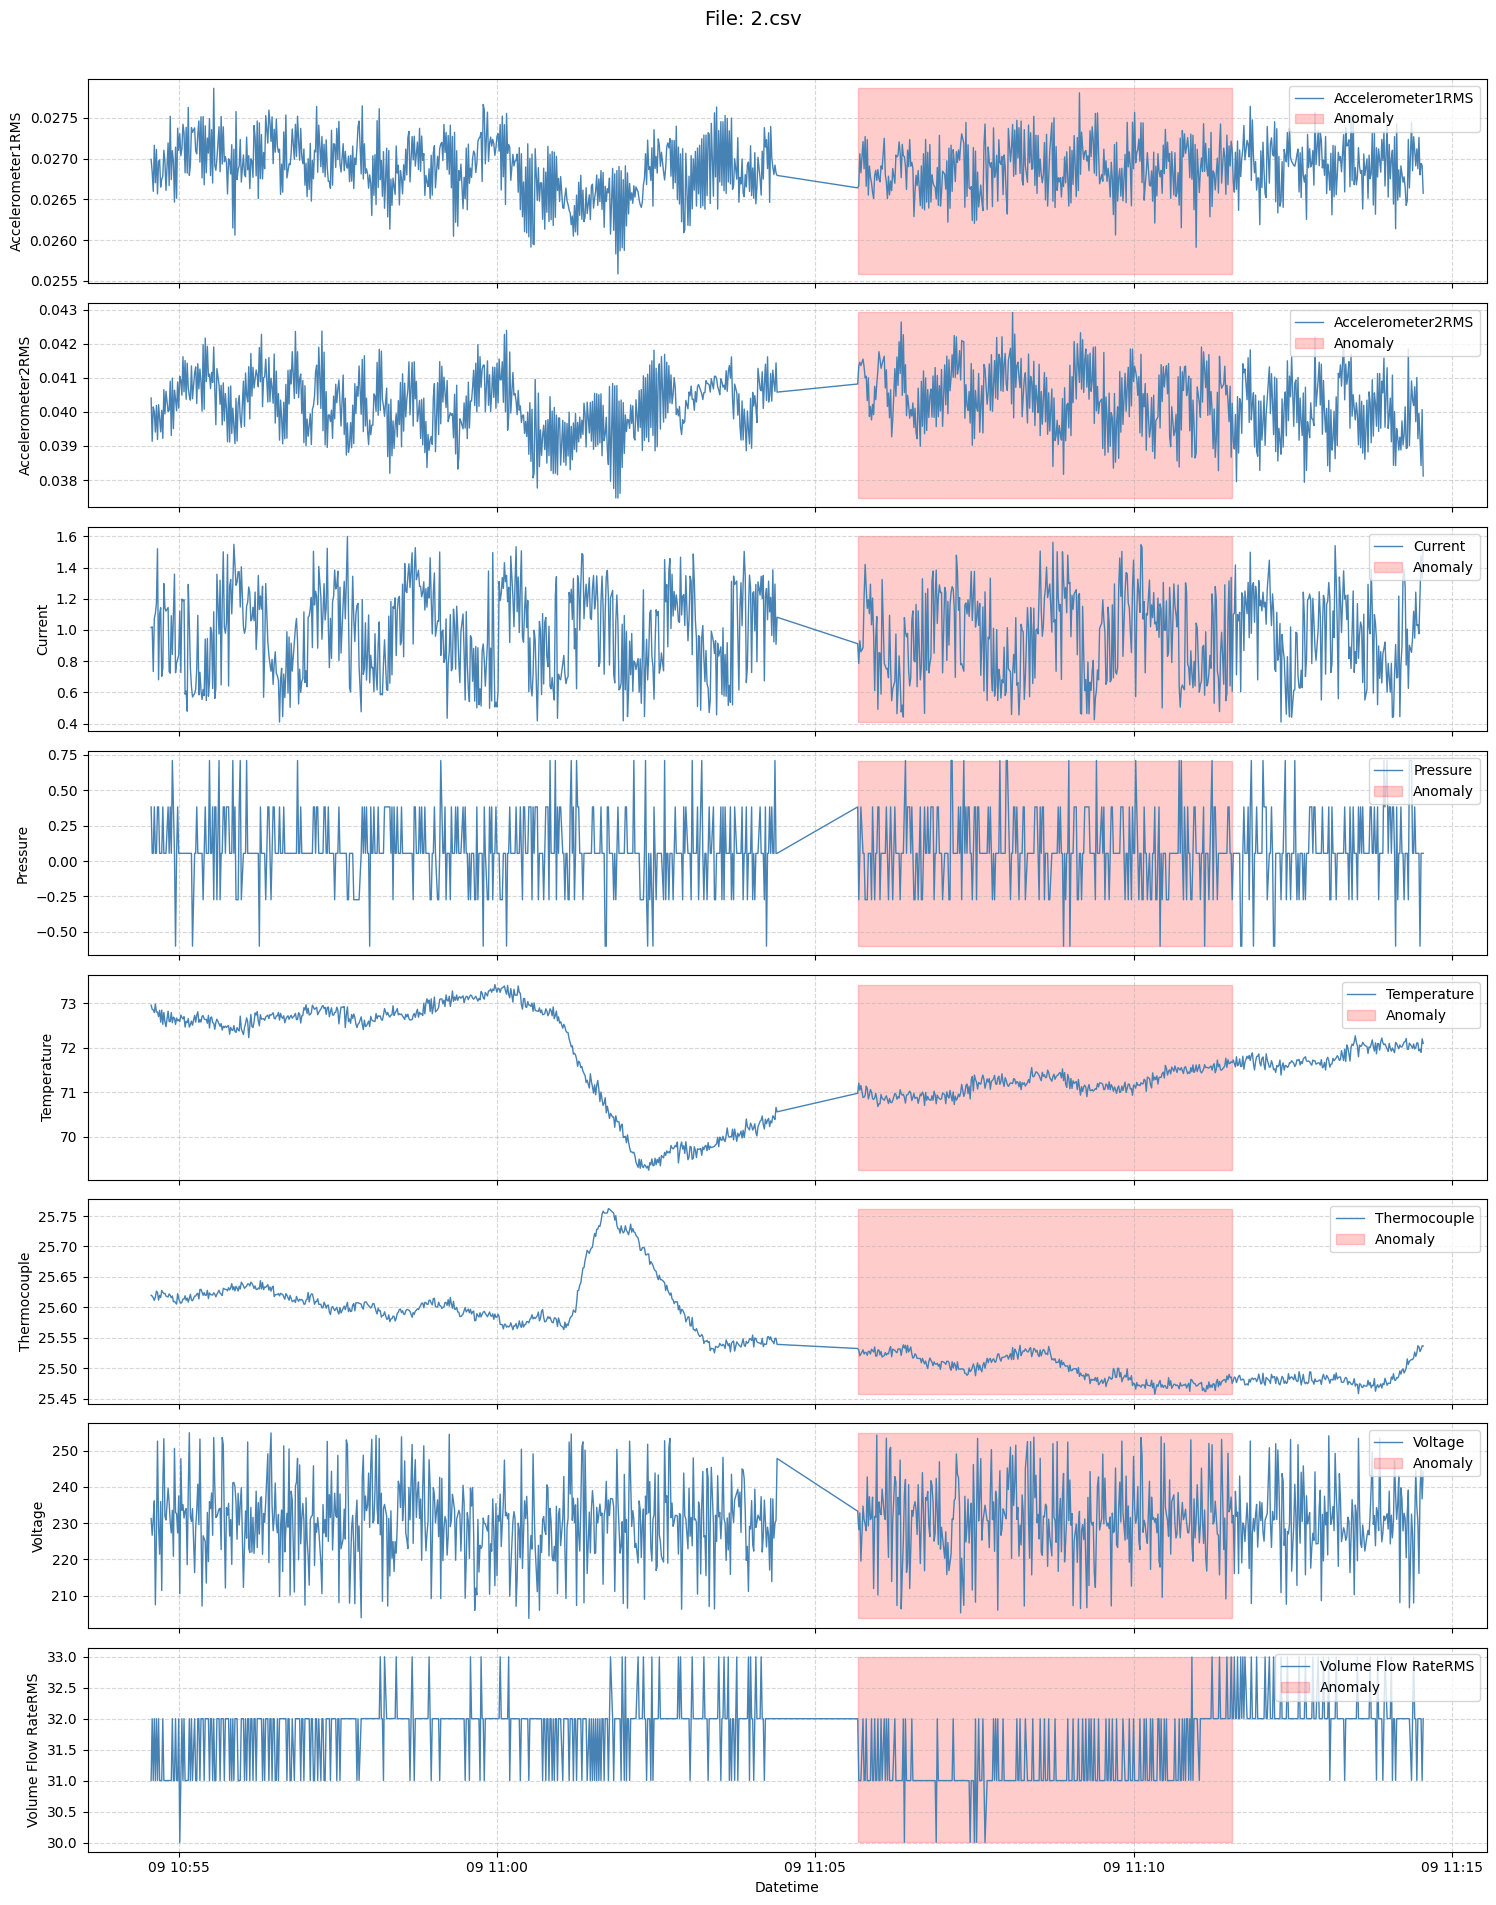

In [7]:
import matplotlib.pyplot as plt

def visualize_skab_data(data, title="SKAB Sensor Signals"):
    # 1. 确定传感器列
    sensor_columns = [col for col in data.columns if col not in ['anomaly', 'changepoint']]

    # 2. 创建子图
    fig, axes = plt.subplots(nrows=len(sensor_columns), ncols=1, 
                             figsize=(15, 2.5 * len(sensor_columns)), 
                             sharex=True, squeeze=False)

    for i, col in enumerate(sensor_columns):
        ax = axes[i, 0]
        ax.plot(data.index, data[col], label=col, color='steelblue', linewidth=1)
        
        # 3. 使用红色阴影标记异常区域
        if 'anomaly' in data.columns:
            ax.fill_between(data.index, data[col].min(), data[col].max(), 
                            where=data['anomaly'] == 1, color='red', alpha=0.2, label='Anomaly')
        
        ax.set_ylabel(col)
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Datetime')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# 调用函数进行可视化
if 'df' in locals():
    visualize_skab_data(df, title=f"File: {os.path.basename(selected_file)}")

# Test with 'timeeval'

## Format trasnformation

Canonical format:
```
timestamp,value,is_anomaly
0,12751.0,1
1,8767.0,0
2,7005.0,0
3,5257.0,0
4,4189.0,0
```

In [17]:
import pandas as pd

file_path = '/home/zepeng/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/anomaly-free/anomaly-free.csv'

# Note: in this dataset, sep=';'
df = pd.read_csv(file_path, sep=';', parse_dates=['datetime'])


# 2. Reset index if 'datetime' is the index
if df.index.name == 'datetime':
    df.reset_index(inplace=True)

df.rename(columns={'datetime': 'timestamp'}, inplace=True)
cols = ['timestamp'] + [c for c in df.columns if c != 'timestamp']
df = df[cols]
df['is_anomaly'] = 0

df.to_csv('skab_anomaly_free.train.csv', index=False)

print("Transformed to conanical format：")
display(df.head())


Transformed to conanical format：


,timestamp,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,is_anomaly
0,2020-02-08 13:30:47,0.206030,0.277924,1.81019,0.382638,90.1740,26.7760,228.208,121.664,0
1,2020-02-08 13:30:48,0.204366,0.275727,2.66317,-0.273216,90.2836,26.7760,227.245,122.000,0
2,2020-02-08 13:30:49,0.206103,0.278526,2.63758,0.382638,89.8666,26.7821,237.872,122.000,0
3,2020-02-08 13:30:51,0.204775,0.276948,2.32851,0.382638,90.2192,26.7773,230.422,121.338,0
4,2020-02-08 13:30:52,0.206052,0.278141,2.53422,0.382638,90.1449,26.7773,219.454,121.664,0


In [23]:
# 1. 读取文件 (注意 SKAB 数据集通常使用分号 ; 作为分隔符)
# 请修改为您的实际文件路径
file_path = '/home/zepeng/.cache/kagglehub/datasets/yuriykatser/skoltech-anomaly-benchmark-skab/versions/1/SKAB/valve1/9.csv' 
df = pd.read_csv(file_path, sep=';', parse_dates=['datetime'])

# ---------------------------------------------------------
# 数据清洗与格式转换
# ---------------------------------------------------------

# 2. 删除不需要的 'changepoint' 列
if 'changepoint' in df.columns:
    df.drop(columns=['changepoint'], inplace=True)

# 3. 重命名列以符合 TimeEval 标准
#    datetime -> timestamp
#    anomaly  -> is_anomaly
df.rename(columns={
    'datetime': 'timestamp', 
    'anomaly': 'is_anomaly'
}, inplace=True)

# 4. 确保标签列是整数格式 (0 或 1)，而不是 0.0
df['is_anomaly'] = df['is_anomaly'].astype(int)

# 5. 调整列顺序
#    顺序必须是: timestamp (第1列) -> 特征数据 (中间) -> is_anomaly (最后1列)
feature_cols = [c for c in df.columns if c not in ['timestamp', 'is_anomaly']]
final_cols = ['timestamp'] + feature_cols + ['is_anomaly']
df = df[final_cols]

# ---------------------------------------------------------
# 保存文件
# ---------------------------------------------------------

# 命名规则建议：数据集名.test.csv
output_filename = 'valve1_9.test.csv'
df.to_csv(output_filename, index=False)

display(df.head())


,timestamp,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,is_anomaly
0,2020-03-09 13:14:38,0.027295,0.042014,0.814746,0.382638,69.5322,24.8213,230.993,32.0,0
1,2020-03-09 13:14:39,0.027732,0.041170,1.469000,0.710565,69.3418,24.8247,245.832,32.0,0
2,2020-03-09 13:14:40,0.028384,0.043189,0.855355,0.054711,69.0999,24.8143,230.777,32.0,0
3,2020-03-09 13:14:41,0.027885,0.042597,0.622471,0.054711,69.1704,24.8202,237.099,32.0,0
4,2020-03-09 13:14:42,0.027380,0.042097,1.181710,0.054711,69.2861,24.8201,227.888,32.0,0
